
# Loan Prediction Analysis with PySpark

This notebook performs data preprocessing and analysis on a loan prediction dataset using PySpark. 
We'll follow these steps:

1. Set up the environment and import required libraries.
2. Load and inspect the dataset.
3. Perform data cleaning and feature engineering.
4. Build and evaluate predictive models.

Let's start by setting up our environment and importing the necessary libraries.


In [1]:

# Install PySpark library version 3.2 for compatibility
!pip install pyspark==3.2

# Import PySpark, SparkSession for data processing, and other libraries for visualization
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 14.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805891 sha256=254ee9c23679c92045aedeccbed922bc87f0b3623fb8c048cc34a7336f32ea1e
  Stored in directory: /root/.cache/pip/wheels/32/97/d3/8b6d964c8700e4fbb561c71638a92ec55dac9be51eb5fea86d
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.3
    Uninstalling pyspark-3.5.3:
      Successfully uninstalled pyspark-3.5.3



## Load and Preview the Dataset

In this step, we initialize a Spark session, load the loan dataset, and display the first few rows to understand its structure.


In [37]:

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize Spark Session
spark = SparkSession.builder.appName("LoanPredictionPartB").getOrCreate()

# Load the loan dataset
loan_data = spark.read.csv('/content/train_loan.csv', header=True, inferSchema=True)

# Display the first 5 rows of the dataset to understand its structure
loan_data.show(5)


+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP001002|  Male|     No|         0|    Graduate|           No|           5849|              0.0|      null|             360|             1|        Urban|          Y|
|LP001003|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|
|LP001005|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|             360|             1|        Urban|          Y


## Inspect Dataset Schema and Summary Statistics

Checking the schema reveals data types of each column and helps identify potential null values.
Summary statistics give insights into numeric columns and help detect any unusual distributions or outliers.


In [38]:

# Display the schema of the dataset
loan_data.printSchema()

# Show basic summary statistics for each column in the dataset
loan_data.describe().show()


root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- Loan_Amount_Term: integer (nullable = true)
 |-- Credit_History: integer (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)

+-------+--------+------+-------+------------------+------------+-------------+-----------------+------------------+------------------+-----------------+------------------+-------------+-----------+
|summary| Loan_ID|Gender|Married|        Dependents|   Education|Self_Employed|  ApplicantIncome| CoapplicantIncome|        LoanAmount| Loan_Amount_Term|    Credit_History|Property_Area|Loan_Status|
+-------+--------+------+---

In [39]:



# Fill missing values for numeric and categorical columns
loan_data = loan_data.fillna({
    'LoanAmount': loan_data.approxQuantile("LoanAmount", [0.5], 0.01)[0],  # Median approximation
    'Loan_Amount_Term': loan_data.approxQuantile("Loan_Amount_Term", [0.5], 0.01)[0],  # Median for Loan Term
    'Credit_History': 1.0,  # Default value assuming credit history exists
    'Gender': 'Male',
    'Married': 'No',
    'Dependents': '0',
    'Self_Employed': 'No',
    'Property_Area': 'Urban'
})


In [40]:
from pyspark.ml.feature import StringIndexer

# Encode categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column + "_index").fit(loan_data)
            for column in ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Dependents']]

for indexer in indexers:
    loan_data = indexer.transform(loan_data)

loan_data = StringIndexer(inputCol="Loan_Status", outputCol="label", handleInvalid="keep").fit(loan_data).transform(loan_data)

In [41]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=['Gender_index', 'Married_index', 'Dependents_index',
               'Education_index', 'Self_Employed_index', 'ApplicantIncome',
               'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term',
               'Credit_History', 'Property_Area_index'],
    outputCol="features")
loan_data = assembler.transform(loan_data)


In [42]:
from pyspark.ml.classification import LogisticRegression

# Initialize and train logistic regression model
lr = LogisticRegression(labelCol="label", featuresCol="features")
lr_model = lr.fit(loan_data)
lr_predictions = lr_model.transform(loan_data)
# Make predictions
lr_predictions = lr_model.transform(loan_data)
lr_predictions.select("Loan_Status", "prediction", "probability").show(5)


+-----------+----------+--------------------+
|Loan_Status|prediction|         probability|
+-----------+----------+--------------------+
|          Y|       0.0|[0.76496664911964...|
|          N|       0.0|[0.77347220345124...|
|          Y|       0.0|[0.85301936354785...|
|          Y|       0.0|[0.76375058039960...|
|          Y|       0.0|[0.76039582811522...|
+-----------+----------+--------------------+
only showing top 5 rows



In [47]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Calculate metrics
accuracy_lr = evaluator.evaluate(lr_predictions, {evaluator.metricName: "accuracy"})
precision_lr = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedPrecision"})
recall_lr = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedRecall"})

print(f"Logistic Regression - Accuracy: {accuracy_lr}, Precision: {precision_lr}, Recall: {recall_lr}")


Logistic Regression - Accuracy: 0.8127035830618893, Precision: 0.8340185110571443, Recall: 0.8127035830618892


In [49]:
from pyspark.ml.classification import DecisionTreeClassifier

# Initialize and train decision tree model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
dt_model = dt.fit(loan_data)

# Make predictions
dt_predictions = dt_model.transform(loan_data)
dt_predictions.select("Loan_Status", "prediction", "probability").show(5)


+-----------+----------+--------------------+
|Loan_Status|prediction|         probability|
+-----------+----------+--------------------+
|          Y|       0.0|[0.75268817204301...|
|          N|       0.0|     [0.79,0.21,0.0]|
|          Y|       0.0|     [0.79,0.21,0.0]|
|          Y|       0.0|     [0.79,0.21,0.0]|
|          Y|       0.0|[0.75268817204301...|
+-----------+----------+--------------------+
only showing top 5 rows



In [50]:
# Calculate metrics for decision tree
accuracy_dt = evaluator.evaluate(dt_predictions, {evaluator.metricName: "accuracy"})
precision_dt = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedPrecision"})
recall_dt = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedRecall"})

print(f"Decision Tree - Accuracy: {accuracy_dt}, Precision: {precision_dt}, Recall: {recall_dt}")


Decision Tree - Accuracy: 0.8338762214983714, Precision: 0.8433704783130465, Recall: 0.8338762214983713


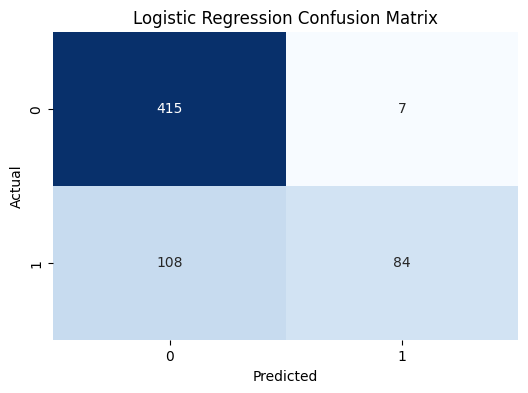

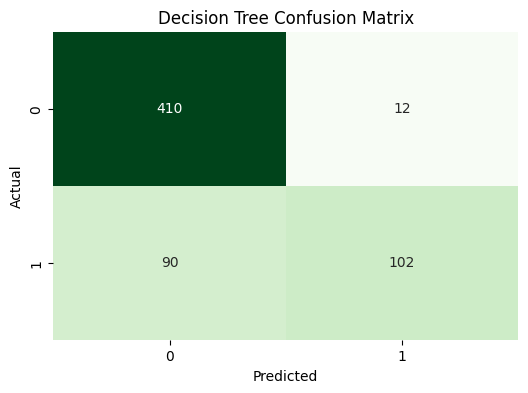

In [52]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Map 'Loan_Status' values ('N' and 'Y') to match 'label' values (0 and 1)
lr_pd = lr_predictions.select("label", "prediction").toPandas()
dt_pd = dt_predictions.select("label", "prediction").toPandas()

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(lr_pd['label'], lr_pd['prediction'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Confusion Matrix for Decision Tree
cm_dt = confusion_matrix(dt_pd['label'], dt_pd['prediction'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
